In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import os
import matplotlib.pyplot as plt
from IPython import display


In [2]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import imageio
import glob

In [4]:
#creating image stream from my Google Drive

generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./ 255)
obj = generator.flow_from_directory(
    '/content/drive/My Drive/Prada',
    target_size=(300, 180),
    shuffle=True,
    batch_size=7,
    class_mode='binary'
)

images = []
#using the obj.next() method, I'm adding the RGB data to the images array
for i in enumerate(range(7)):
  img, label = obj.next()
  images.append(img)

img = images[0]
for idx in range(len(images) - 1):
    img = np.vstack((img, images[idx + 1]))
print(img.shape)



Found 40 images belonging to 2 classes.
(47, 300, 180, 3)


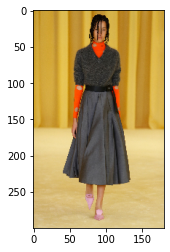

In [ ]:
plt.imshow(images[1][0])

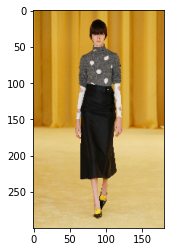

In [ ]:
plt.imshow(img[4])

In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(5*3*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((5,3,256)))
  assert model.output_shape == (None, 5,3,256)

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 5, 3, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(5,5), padding='same', use_bias=False))
  assert model.output_shape == (None, 25, 15, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(3,3), padding='same', use_bias=False))
  assert model.output_shape == (None, 75, 45, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 150, 90, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 300, 180, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 300, 180, 3)

  return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3840)              384000    
_________________________________________________________________
batch_normalization (BatchNo (None, 3840)              15360     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3840)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 3, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 3, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 3, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 3, 128)         0

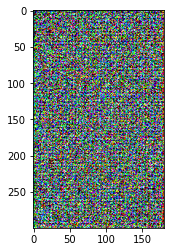

In [ ]:
generator = generator_model()
generator.summary()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,:]*10000)

In [ ]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(1,1), padding='same', input_shape=(300,180,3)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [5]:
generator = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

In [ ]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-5.3594835e-05]], shape=(1, 1), dtype=float32)


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_losses(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#establish checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [8]:
BATCH_SIZE = 7
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_losses(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
import time

def train(datasets, epoch):
  for e in range(epoch):
    start = time.time()

    for image_batch in datasets:
      print(e)
      fig = plt.figure(figsize=(3,3))
      for i in range(len(image_batch)):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i])
        plt.axis('off')
      train_step(image_batch)

      display.clear_output(wait=True)
      generate_and_save_images(generator,
                                e +1,
                                seed)
      
          # Save the model every 15 epochs
      if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(e + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             e,
                             seed)

In [10]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow(predictions[i,:,:,:])
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

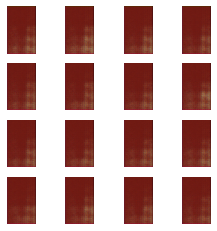

In [ ]:
img = img.reshape(47,1,300,180,3)
discriminator.summary()
train(images, 10)

ls: cannot access '/training_checkpoints': No such file or directory


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


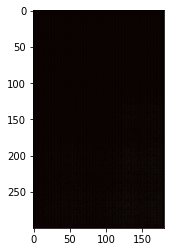

In [ ]:
!ls /training_checkpoints
plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

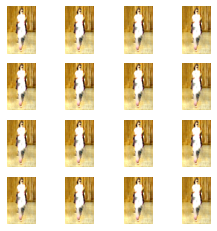

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


In [11]:
train(images, 50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

In [ ]:
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


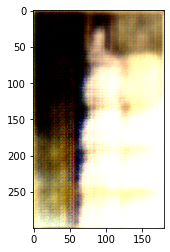

In [ ]:
plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

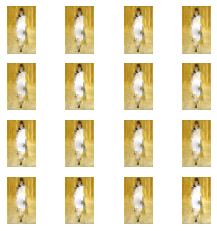

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


In [ ]:
train(images, 50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

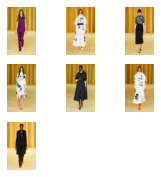

In [ ]:
train(images, 50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

In [ ]:
train(images,50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

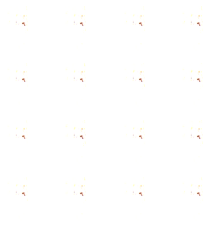

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


In [ ]:
train(images, 50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

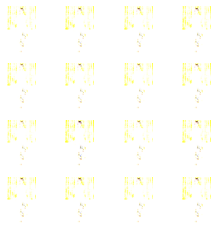

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


In [ ]:
train(images, 50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

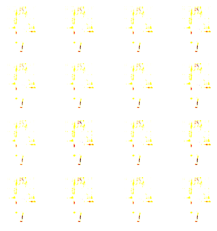

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator/assets


In [ ]:
train(images,50)
generator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/generator')
discriminator.save('/content/drive/My Drive/Colab Notebooks/Original Pradanator/discriminator')

In [ ]:
generator.save
discriminator.save

<bound method Model.save of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f78a7e84fd0>>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


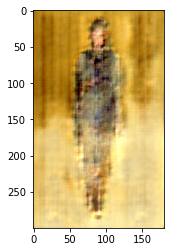

In [ ]:
plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0,:,:,:])